In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import numpy as np
import lime
import lime.lime_tabular
from sklearn.model_selection import cross_val_score

In [2]:
# Load the dataset
dataset = pd.read_csv('dataset_churn.csv')

In [3]:
# Preview the dataset
dataset.head()

Unnamed: 0                            CustomerID   Age  Gender  Tenure  \
0           0  08729464-bde6-43bc-8f63-a357096feab1  56.0    Male      13   
1           1  af95bc95-baf4-4318-a21d-70d2ea3148b7  69.0    Male      13   
2           2  1fe7eee6-2227-4400-9998-4d993f4a60fd  46.0    Male      60   
3           3  f736fe7b-1b44-4acd-84c2-21c4aef648be  32.0  Female      57   
4           4  4b40d12d-7633-4309-96b8-aee675ea20ae  60.0    Male      52   

  Service_Internet Service_Phone Service_TV        Contract     PaymentMethod  \
0              DSL           Yes         No        One year      Mailed check   
1              DSL            No        Yes        Two year      Mailed check   
2      Fiber optic            No        Yes  Month-to-month      Mailed check   
3      Fiber optic           Yes        Yes  Month-to-month     Bank transfer   
4      Fiber optic           Yes        Yes        Two year  Electronic check   

   MonthlyCharges  TotalCharges StreamingMovies StreamingMusic OnlineSecurity  \
0           71.88        931.49              No             No            Yes   
1          110.99       1448.46             Yes            Yes             No   
2          116.74       6997.73             Yes            Yes             No   
3           78.16       4452.13              No            Yes             No   
4           30.33       1569.73             Yes             No            Yes   

  TechSupport Churn  
0          No    No  
1          No    No  
2          No    No  
3         Yes    No  
4         Yes    No

In [4]:
# Strip any leading/trailing spaces from the column names
dataset.columns = dataset.columns.str.strip()

# Remove unnecessary columns
dataset = dataset.drop(columns=['Unnamed: 0', 'CustomerID'])

# Check the dataser after removing unnecessary columns
dataset.head()

Age  Gender  Tenure Service_Internet Service_Phone Service_TV  \
0  56.0    Male      13              DSL           Yes         No   
1  69.0    Male      13              DSL            No        Yes   
2  46.0    Male      60      Fiber optic            No        Yes   
3  32.0  Female      57      Fiber optic           Yes        Yes   
4  60.0    Male      52      Fiber optic           Yes        Yes   

         Contract     PaymentMethod  MonthlyCharges  TotalCharges  \
0        One year      Mailed check           71.88        931.49   
1        Two year      Mailed check          110.99       1448.46   
2  Month-to-month      Mailed check          116.74       6997.73   
3  Month-to-month     Bank transfer           78.16       4452.13   
4        Two year  Electronic check           30.33       1569.73   

  StreamingMovies StreamingMusic OnlineSecurity TechSupport Churn  
0              No             No            Yes          No    No  
1             Yes            Yes             No          No    No  
2             Yes            Yes             No          No    No  
3              No            Yes             No         Yes    No  
4             Yes             No            Yes         Yes    No

In [5]:
# Check the dataset shape and describe the data
print(f"Dataset shape: {dataset.shape}")
print(dataset.describe())

Dataset shape: (3749, 15)
               Age       Tenure  MonthlyCharges  TotalCharges
count  3562.000000  3749.000000     3749.000000   3749.000000
mean     43.655531    36.264070       75.844318   2718.968266
std      14.914474    20.505528       73.062971   3211.879149
min      18.000000     1.000000       20.000000     13.190000
25%      31.000000    19.000000       44.570000   1076.240000
50%      44.000000    36.000000       69.590000   2132.260000
75%      56.000000    54.000000       95.540000   3619.710000
max      69.000000    71.000000     1179.300000  79951.800000


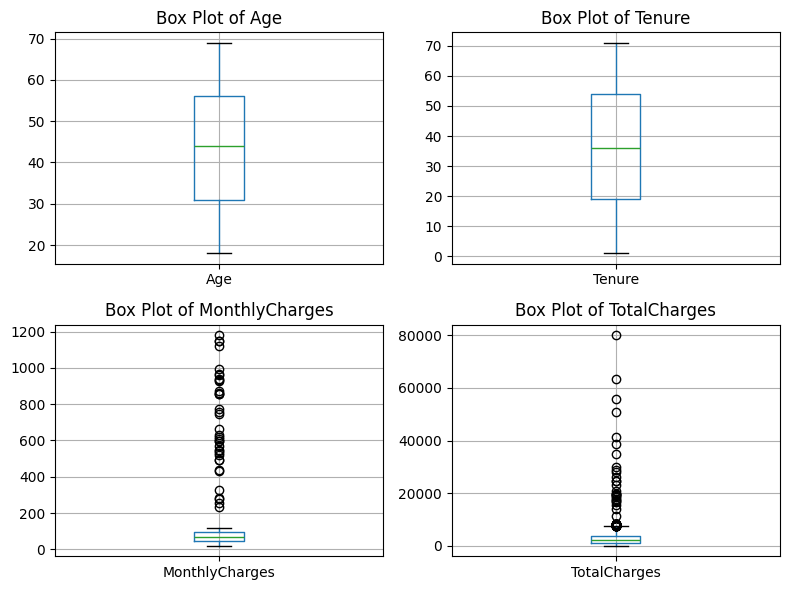

In [6]:
# Visualizing numerical features with box plots
numerical_columns = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(8, 6))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    dataset.boxplot(column=column)
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

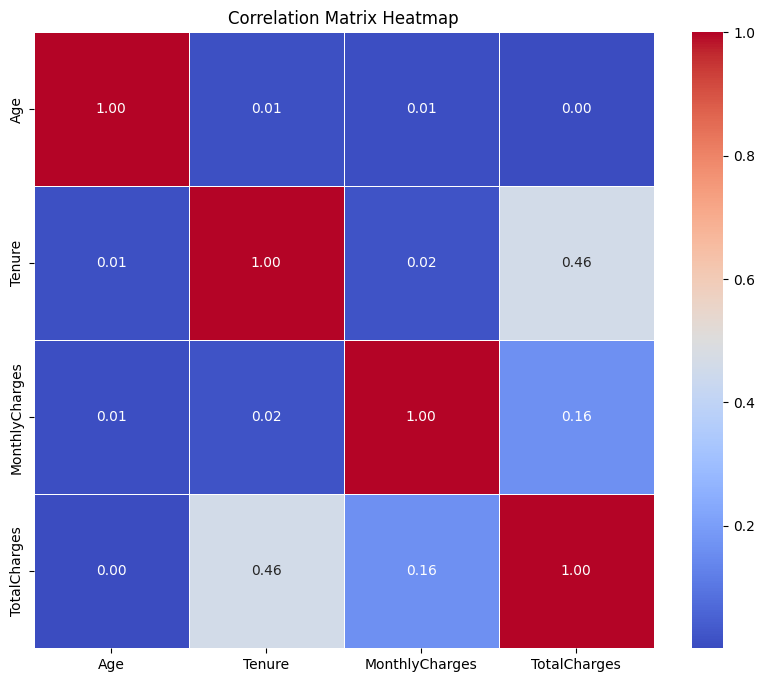

In [7]:
# Generating the correlation matrix
correlation_matrix = dataset[numerical_columns].corr()

# Plotting the correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [8]:
# Check for the missing values
dataset.isnull().sum()

Age                 187
Gender                0
Tenure                0
Service_Internet    721
Service_Phone         0
Service_TV            0
Contract              0
PaymentMethod       187
MonthlyCharges        0
TotalCharges          0
StreamingMovies       0
StreamingMusic        0
OnlineSecurity        0
TechSupport           0
Churn                 0
dtype: int64

In [9]:
# Handle missing values using median for numeric columns and mode for categorical columns
imputer_median = SimpleImputer(strategy='median')
dataset['Age'] = imputer_median.fit_transform(dataset[['Age']]).ravel()

imputer_mode = SimpleImputer(strategy='most_frequent')
dataset['PaymentMethod'] = imputer_mode.fit_transform(dataset[['PaymentMethod']]).ravel()
dataset['Service_Internet'] = imputer_mode.fit_transform(dataset[['Service_Internet']]).ravel()

In [10]:
# Check for remaining missing values
print(dataset.isnull().sum())

Age                 0
Gender              0
Tenure              0
Service_Internet    0
Service_Phone       0
Service_TV          0
Contract            0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
StreamingMovies     0
StreamingMusic      0
OnlineSecurity      0
TechSupport         0
Churn               0
dtype: int64


In [11]:
# Label encode categorical columns
categorical_features = ['Gender', 'Service_Internet', 'Service_Phone', 'Service_TV',
                         'Contract', 'PaymentMethod', 'StreamingMovies', 'StreamingMusic',
                         'OnlineSecurity', 'TechSupport', 'Churn']

labelencoder = LabelEncoder()
dataset[categorical_features] = dataset[categorical_features].apply(labelencoder.fit_transform)

In [12]:
# Clipping outliers based on the IQR method
columns_to_clip = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']

for column in columns_to_clip:
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    dataset[column] = np.clip(dataset[column], lower_bound, upper_bound)

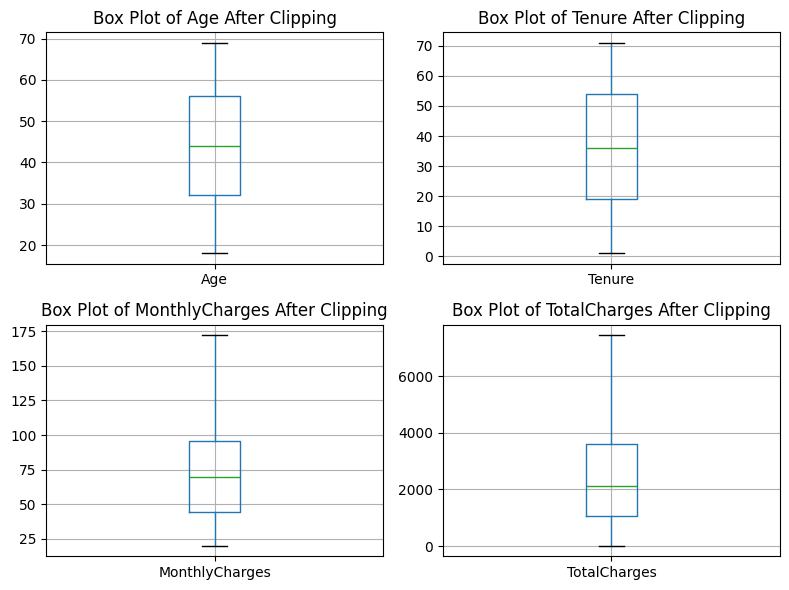

In [13]:
# Visualize the distribution after clipping
plt.figure(figsize=(8, 6))
for i, column in enumerate(columns_to_clip, 1):
    plt.subplot(2, 2, i)
    dataset.boxplot(column=column)
    plt.title(f'Box Plot of {column} After Clipping')
plt.tight_layout()
plt.show()

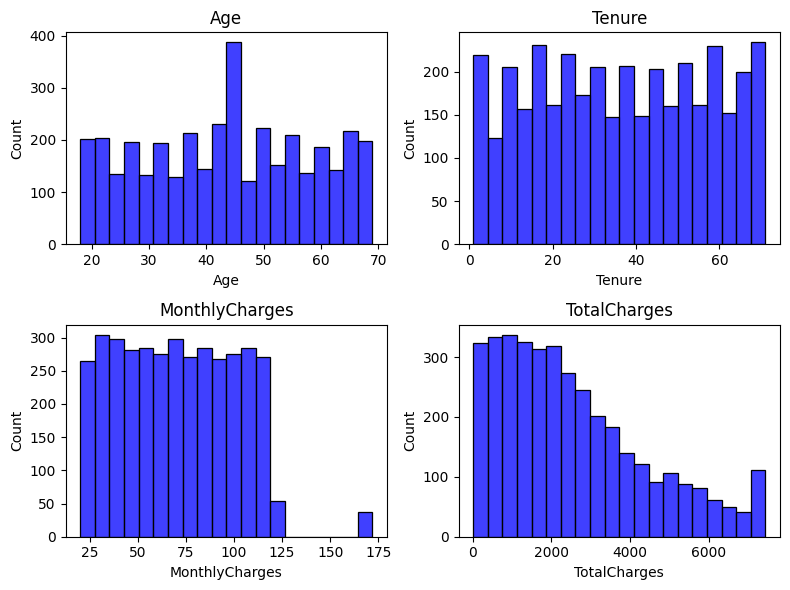

In [14]:
# Visualizing distribution of numerical features with histograms
plt.figure(figsize=(8, 6))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(dataset[column], bins=20, color='blue')
    plt.title(f'{column}')
plt.tight_layout()
plt.show()

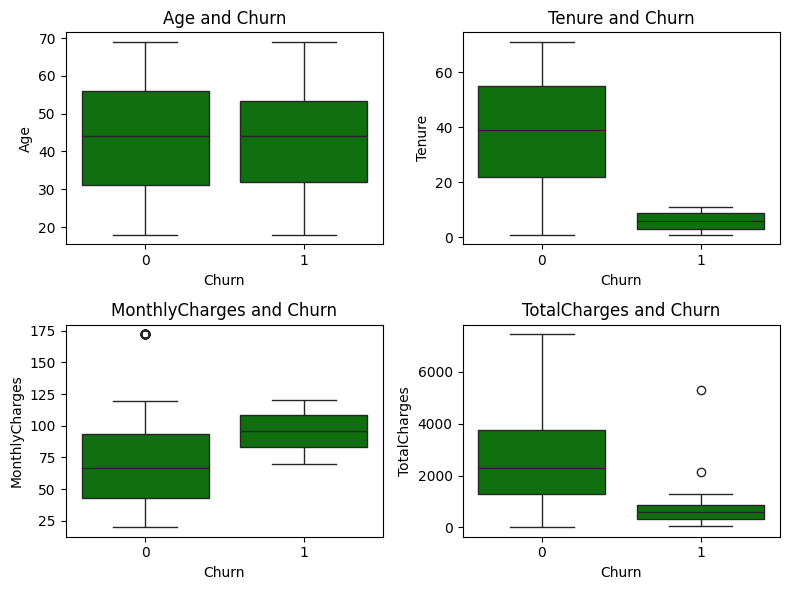

In [15]:
# Box plots for numerical features vs Churn
plt.figure(figsize=(8, 6))
for i, col in enumerate(numerical_columns):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='Churn', y=col, data=dataset, color='green')
    plt.title(f'{col} and Churn')
    plt.tight_layout()

plt.show()

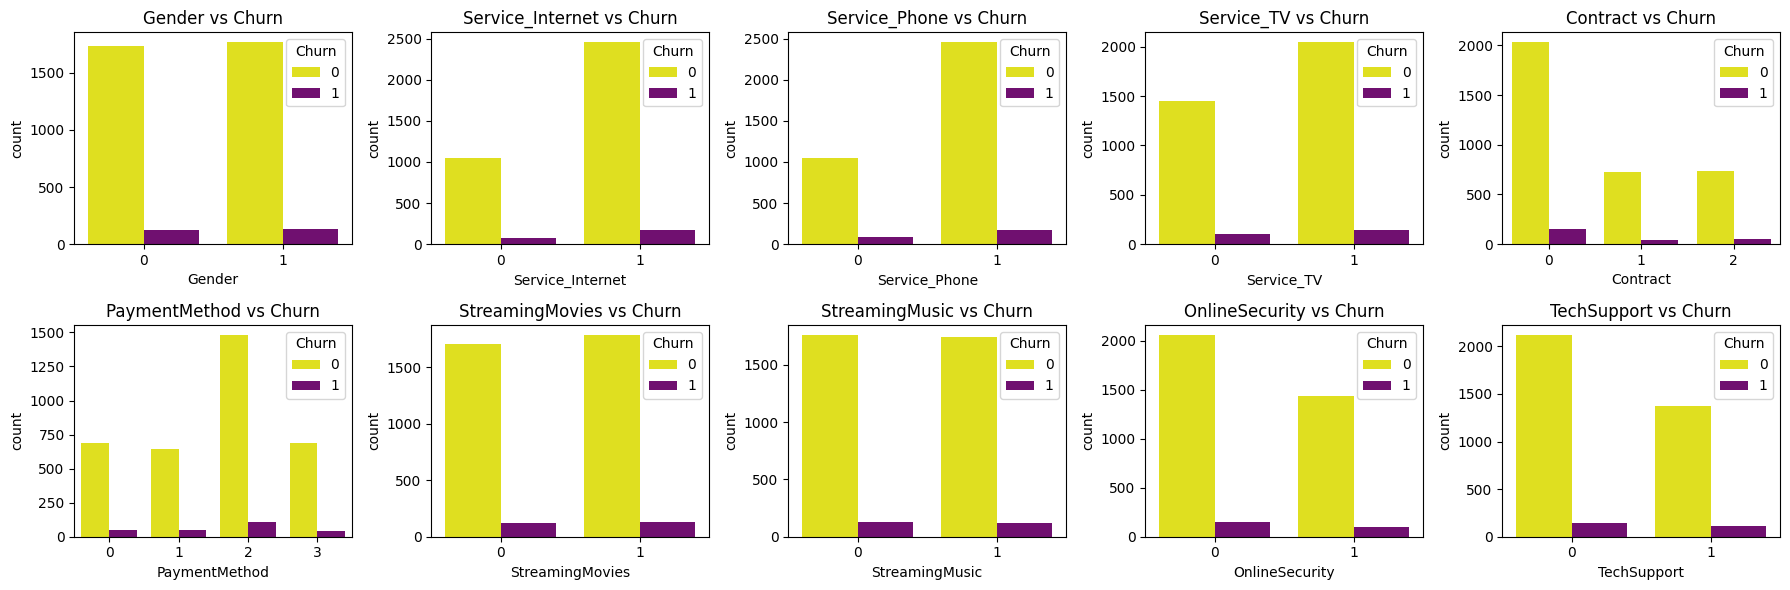

In [16]:
# Count plots for categorical features vs Churn
cats = ['Gender', 'Service_Internet', 'Service_Phone', 'Service_TV', 'Contract', 'PaymentMethod', 'StreamingMovies', 'StreamingMusic', 'OnlineSecurity', 'TechSupport']

plt.figure(figsize=(18, 6))
for i, col in enumerate(cats):
    plt.subplot(2, 5, i + 1)
    sns.countplot(x=col, hue='Churn', data=dataset, palette=['yellow', 'purple'])
    plt.title(f'{col} vs Churn')
plt.tight_layout()
plt.show()

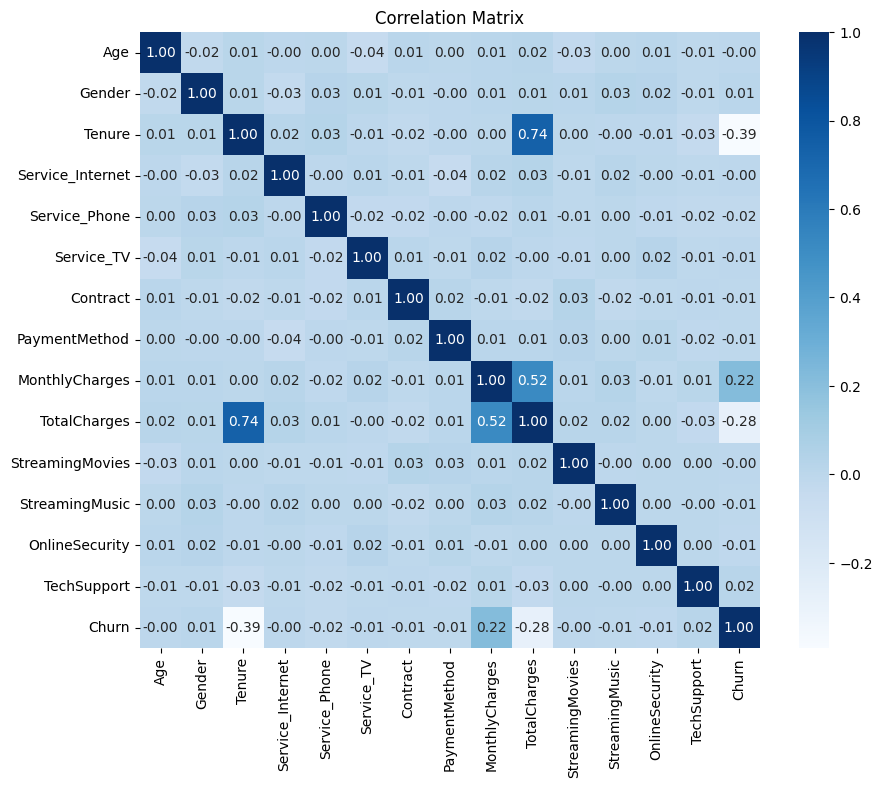

In [17]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [18]:
# Chi-Square test for categorical features
X_categorical = dataset[['Gender', 'Service_Internet', 'Service_Phone', 'Service_TV',
                         'Contract', 'PaymentMethod', 'StreamingMovies', 'StreamingMusic',
                         'OnlineSecurity', 'TechSupport']]
Y = dataset['Churn']

chi_scores, p_values = chi2(X_categorical, Y)

chi_square_results = pd.DataFrame({
    'Feature': X_categorical.columns,
    'Chi-Square Score': chi_scores,
    'p-value': p_values
}).sort_values(by='p-value')

print("Chi-Square Test Results for Categorical Features:")
print(chi_square_results)

Chi-Square Test Results for Categorical Features:
            Feature  Chi-Square Score   p-value
9       TechSupport          0.780247  0.377065
4          Contract          0.534231  0.464834
2     Service_Phone          0.439102  0.507556
8    OnlineSecurity          0.339420  0.560164
5     PaymentMethod          0.229804  0.631669
7    StreamingMusic          0.171462  0.678816
0            Gender          0.082627  0.773768
3        Service_TV          0.045332  0.831394
6   StreamingMovies          0.036121  0.849267
1  Service_Internet          0.024715  0.875080


In [19]:
# Feature engineering
new_dataset = dataset.copy()
new_dataset['TotalServices'] = (new_dataset['Service_Internet'] + new_dataset['Service_Phone'] + new_dataset['Service_TV'] + new_dataset['OnlineSecurity'] + new_dataset['TechSupport'])
new_dataset['CLV'] = new_dataset['MonthlyCharges'] * new_dataset['Tenure']
new_dataset['AvgMonthlyChargeOverTenure'] = new_dataset['TotalCharges'] / (new_dataset['Tenure'] + 1)
new_dataset['RecentPaymentDrop'] = new_dataset['MonthlyCharges'] / new_dataset['AvgMonthlyChargeOverTenure']

# Save the modified dataset
new_dataset.to_csv('new_dataset.csv', index=False, sep=';')

# Prepare features and target variable
X = new_dataset.drop('Churn', axis=1)
Y = new_dataset['Churn']

In [20]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

Training Features Shape: (2999, 18)
Testing Features Shape: (750, 18)


In [21]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Function to train and evaluate models
def train_evaluate_plot(model, model_name, X_train_scaled, X_test_scaled, Y_train, Y_test):
    model.fit(X_train_scaled, Y_train)
    Y_pred = model.predict(X_test_scaled)

    print(f'{model_name} accuracy: {accuracy_score(Y_test, Y_pred):.4f}')
    
    if hasattr(model, "predict_proba"):
        Y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        print(f'{model_name} ROC-AUC: {roc_auc_score(Y_test, Y_pred_proba):.4f}\n')

    print(classification_report(Y_test, Y_pred))
    sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    cv_scores = cross_val_score(model, X_train_scaled, Y_train, cv=5, scoring='accuracy')
    print(f'{model_name} Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

Logistic Regression accuracy: 0.9827
Logistic Regression ROC-AUC: 0.9954

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       707
           1       0.86      0.84      0.85        43

    accuracy                           0.98       750
   macro avg       0.92      0.91      0.92       750
weighted avg       0.98      0.98      0.98       750



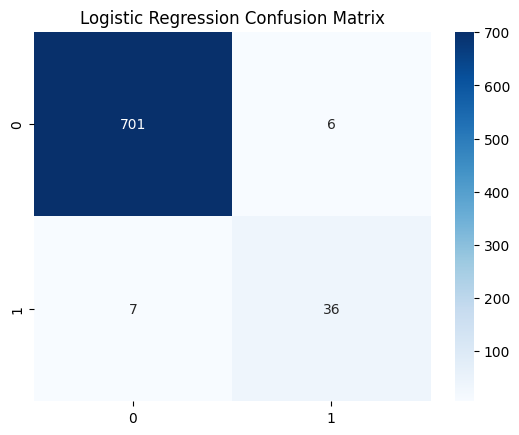

Logistic Regression Cross-Validation Accuracy: 0.9817 ± 0.0046


In [23]:
# Train and evaluate different models
train_evaluate_plot(LogisticRegression(random_state=42), "Logistic Regression", X_train_scaled, X_test_scaled, Y_train, Y_test)

Decision Tree accuracy: 0.9987
Decision Tree ROC-AUC: 0.9993

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



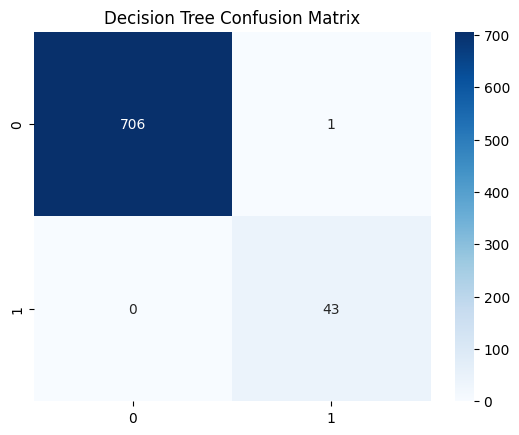

Decision Tree Cross-Validation Accuracy: 0.9990 ± 0.0013


In [24]:
train_evaluate_plot(DecisionTreeClassifier(random_state=42), "Decision Tree", X_train_scaled, X_test_scaled, Y_train, Y_test)

Random Forest accuracy: 0.9987
Random Forest ROC-AUC: 1.0000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



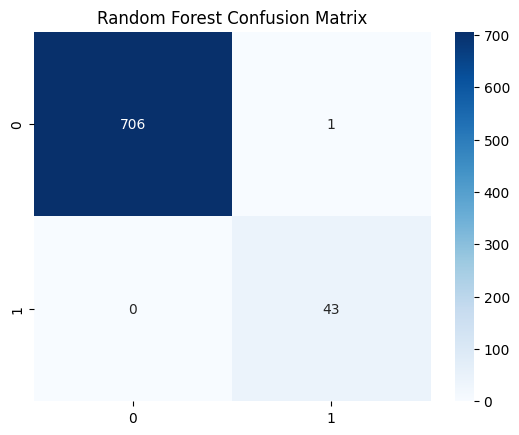

Random Forest Cross-Validation Accuracy: 0.9987 ± 0.0012


In [25]:
train_evaluate_plot(RandomForestClassifier(random_state=42), "Random Forest", X_train_scaled, X_test_scaled, Y_train, Y_test)

Gradient Boosting accuracy: 0.9987
Gradient Boosting ROC-AUC: 0.9993

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



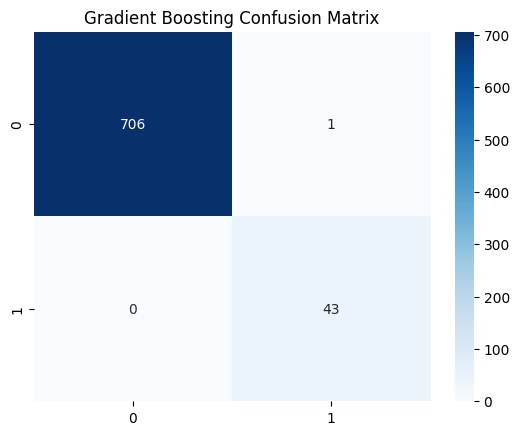

Gradient Boosting Cross-Validation Accuracy: 0.9990 ± 0.0013


In [26]:
train_evaluate_plot(GradientBoostingClassifier(random_state=42), "Gradient Boosting", X_train_scaled, X_test_scaled, Y_train, Y_test)

In [27]:
# Hyperparameter grids for models
param_grid_logistic = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200]
}

param_grid_decision_tree = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_random_forest = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_gradient_boosting = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [28]:
# Grid search for hyperparameter tuning
def grid_search_eval(model_name, model, param_grid):
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
    
    # Try fitting the model and handle possible issues
    try:
        grid_search.fit(X_train_scaled, Y_train)
    except Exception as e:
        print(f"Error during grid search for {model_name}: {e}")
        return None

    # Extract the best model
    best_model = grid_search.best_estimator_

    # Predict and evaluate
    try:
        Y_pred = best_model.predict(X_test_scaled)
        print(f"{model_name} Best params: {grid_search.best_params_}")
        print(f"Best CV accuracy: {grid_search.best_score_:.2f}")
        print(f"Test accuracy: {accuracy_score(Y_test, Y_pred):.4f}")

        if hasattr(best_model, "predict_proba"):
            Y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
            print(f"ROC-AUC: {roc_auc_score(Y_test, Y_pred_proba):.4f}\n")

        print(classification_report(Y_test, Y_pred))
        sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d', cmap="Blues")
        plt.title(f'{model_name} Confusion Matrix')
        plt.show()
    except Exception as e:
        print(f"Error during prediction and evaluation for {model_name}: {e}")
        return None

    return best_model

Logistic Regression Best params: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
Best CV accuracy: 0.98
Test accuracy: 0.9840
ROC-AUC: 0.9961

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       707
           1       0.86      0.86      0.86        43

    accuracy                           0.98       750
   macro avg       0.93      0.93      0.93       750
weighted avg       0.98      0.98      0.98       750



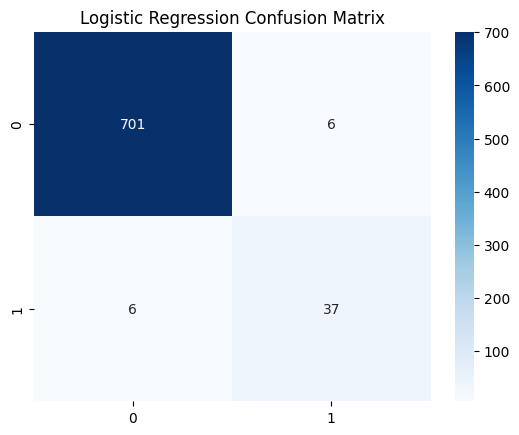

In [29]:
# Perform grid search for all algorithms
best_logistic_regression = grid_search_eval("Logistic Regression", LogisticRegression(random_state=42), param_grid_logistic)

Decision Tree Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV accuracy: 1.00
Test accuracy: 0.9987
ROC-AUC: 0.9993

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



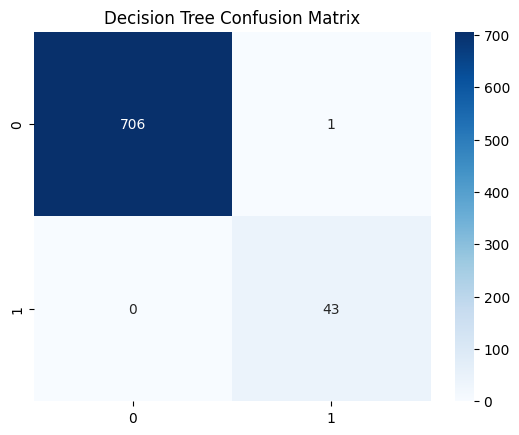

In [30]:
best_decision_tree = grid_search_eval("Decision Tree", DecisionTreeClassifier(random_state=42), param_grid_decision_tree)

Random Forest Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV accuracy: 1.00
Test accuracy: 0.9987
ROC-AUC: 1.0000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



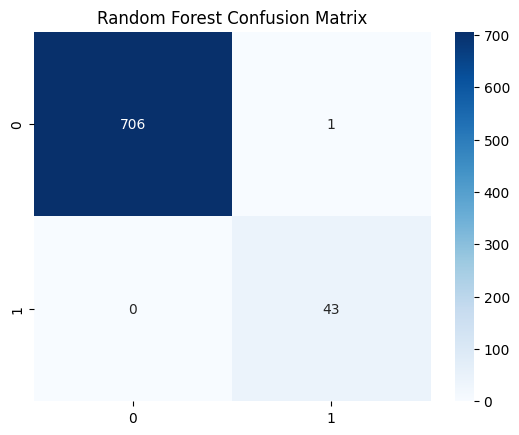

In [31]:
best_random_forest = grid_search_eval("Random Forest", RandomForestClassifier(random_state=42), param_grid_random_forest)

Gradient Boosting Best params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV accuracy: 1.00
Test accuracy: 0.9987
ROC-AUC: 0.9993

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



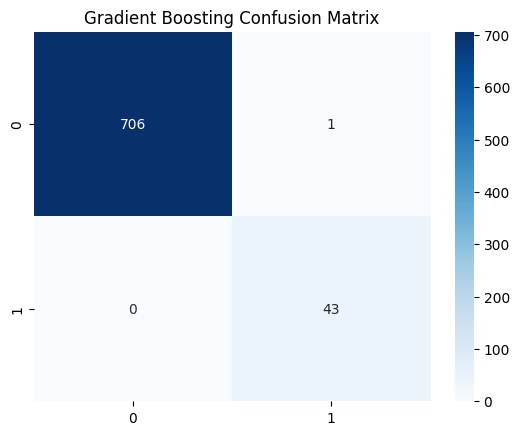

In [32]:
best_gradient_boosting = grid_search_eval("Gradient Boosting", GradientBoostingClassifier(random_state=42), param_grid_gradient_boosting)

In [33]:
# Function to interpret models using LIME
def interpret_model_with_lime(model, model_name, X_train_scaled, X_test_scaled, feature_names):
    if model is not None:
        # Model interpretation using LIME
        explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=np.array(X_train_scaled),
            feature_names=feature_names,
            class_names=['Not Churn', 'Churn'],
            mode='classification'
        )
        sample_instance = X_test_scaled[0]
        exp = explainer.explain_instance(data_row=sample_instance, predict_fn=model.predict_proba)
        print(f'{model_name}')
        exp.show_in_notebook(show_table=True)
    else:
        print(f"Error: {model_name} model was not successfully trained. Skipping LIME explanation.")

In [34]:
interpret_model_with_lime(best_logistic_regression, "Logistic Regression", X_train_scaled, X_test_scaled, X.columns)

Logistic Regression


In [35]:
interpret_model_with_lime(best_decision_tree, "Decision Tree", X_train_scaled, X_test_scaled, X.columns)

Decision Tree


In [36]:
interpret_model_with_lime(best_random_forest, "Random Forest", X_train_scaled, X_test_scaled, X.columns)

Random Forest


In [37]:
interpret_model_with_lime(best_gradient_boosting, "Gradient Boosting", X_train_scaled, X_test_scaled, X.columns)

Gradient Boosting


In [38]:
# Function to display feature importance
def display_feature_importance(model, model_name, feature_names):
    if model is not None:
        print(f"\n{model_name} Feature Importance:")

        if hasattr(model, 'coef_'):
            # Logistic Regression: Feature importance comes from model coefficients
            for coef, name in sorted(zip(model.coef_[0], feature_names), reverse=True):
                print(f"{round(coef, 5)} {name}")
        elif hasattr(model, 'feature_importances_'):
            # Decision Tree, Random Forest, Gradient Boosting: Feature importance from feature_importances_
            for score, name in sorted(zip(model.feature_importances_, feature_names), reverse=True):
                print(f"{round(score, 5)} {name}")
        else:
            print(f"{model_name} has no feature importance available.")
    else:
        print(f"Error: {model_name} model was not successfully trained. Skipping feature importance.")

In [39]:
if best_logistic_regression is not None:
    best_logistic_regression.fit(X_train_scaled, Y_train)
    display_feature_importance(best_logistic_regression, "Logistic Regression", X.columns)
else:
    print("Error: Logistic Regression model was not successfully trained. Skipping feature importance.")


Logistic Regression Feature Importance:
5.98187 MonthlyCharges
4.36535 Tenure
0.5487 AvgMonthlyChargeOverTenure
0.11675 Gender
0.1107 Age
0.05629 Service_Internet
0.05002 Contract
0.03029 StreamingMovies
0.02752 OnlineSecurity
0.02507 Service_Phone
0.01993 PaymentMethod
-0.00188 TechSupport
-0.06467 TotalServices
-0.09601 StreamingMusic
-0.23911 Service_TV
-1.00897 RecentPaymentDrop
-6.08876 TotalCharges
-13.78964 CLV


In [40]:
if best_decision_tree is not None:
    best_decision_tree.fit(X_train_scaled, Y_train)
    display_feature_importance(best_decision_tree, "Decision Tree", X.columns)
else:
    print("Error: Decision Tree model was not successfully trained. Skipping feature importance.")


Decision Tree Feature Importance:
0.58223 MonthlyCharges
0.41777 Tenure
0.0 TotalServices
0.0 TotalCharges
0.0 TechSupport
0.0 StreamingMusic
0.0 StreamingMovies
0.0 Service_TV
0.0 Service_Phone
0.0 Service_Internet
0.0 RecentPaymentDrop
0.0 PaymentMethod
0.0 OnlineSecurity
0.0 Gender
0.0 Contract
0.0 CLV
0.0 AvgMonthlyChargeOverTenure
0.0 Age


In [41]:
if best_random_forest is not None:
    best_random_forest.fit(X_train_scaled, Y_train)
    display_feature_importance(best_random_forest, "Random Forest", X.columns)
else:
    print("Error: Random Forest model was not successfully trained. Skipping feature importance.")


Random Forest Feature Importance:
0.24104 Tenure
0.23833 MonthlyCharges
0.1638 AvgMonthlyChargeOverTenure
0.15951 RecentPaymentDrop
0.09719 CLV
0.07946 TotalCharges
0.00609 Age
0.00268 TotalServices
0.00205 PaymentMethod
0.0015 Contract
0.00122 StreamingMovies
0.00116 Service_TV
0.00115 TechSupport
0.00113 StreamingMusic
0.0011 Service_Phone
0.001 OnlineSecurity
0.0009 Service_Internet
0.00069 Gender


In [42]:
if best_gradient_boosting is not None:
    best_gradient_boosting.fit(X_train_scaled, Y_train)
    display_feature_importance(best_gradient_boosting, "Gradient Boosting", X.columns)
else:
    print("Error: Gradient Boosting model was not successfully trained. Skipping feature importance.")


Gradient Boosting Feature Importance:
0.58223 MonthlyCharges
0.41777 Tenure
0.0 AvgMonthlyChargeOverTenure
0.0 Age
0.0 RecentPaymentDrop
0.0 CLV
0.0 TotalServices
0.0 TechSupport
0.0 StreamingMusic
0.0 StreamingMovies
0.0 Service_TV
0.0 Service_Phone
0.0 Service_Internet
0.0 PaymentMethod
0.0 OnlineSecurity
0.0 Gender
0.0 Contract
-0.0 TotalCharges
